In [73]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [2]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio
import matplotlib.gridspec as gridspec


Populating the interactive namespace from numpy and matplotlib


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [3]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [174]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [176]:
#dc.list_measurements()

In [6]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [7]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range


vec_fname = '/g/data/r78/lxl554/hovmoller/Mary River1.shp' #comment these lines out if running without polygon
src = fiona.open(vec_fname)
geom = shape(src[0]['geometry'])




#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

#query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
lat_max = -38.25
lat_min = -38.45
lon_max = 141.7
lon_min = 141.3
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

"lat_max = -17.35\nlat_min = -17.45\nlon_max = 140.90522\nlon_min = 140.8585\nquery['x'] = (lon_min, lon_max)\nquery['y'] = (lat_max, lat_min)\nquery['crs'] = 'EPSG:4326'"

In [8]:
print query

{'y': (-12.41808654338135, -12.3874225243109), 'x': (131.6553058821664, 131.7168189381293), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-12-31')}


## PQ and Index preparation


In [9]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [10]:
#load sensor specific band adjustment tuples for TSS and brightness
brightness_coeff = {}
brightness_coeff['ls5'] = (0.304, 0.279, 0.434, 0.559, 0.508, 0.186)
brightness_coeff['ls7'] = (0.304, 0.279, 0.434, 0.559, 0.508, 0.186)
#brightness_coeff['ls7'] = (0.3561, 0.3972, 0.3904, 0.6966, 0.2286, 0.1596)
brightness_coeff['ls8'] = (0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872)

greenness_coeff = {}
greenness_coeff['ls5'] = (-0.285, -0.244, -0.544, 0.724, 0.084, -0.180)
greenness_coeff['ls7'] = (-0.285, -0.244, -0.544, 0.724, 0.084, -0.180)
#greenness_coeff['ls7'] = (-0.3344, -0.3544, -0.4556, 0.6966, -0.0242, -0.263)
greenness_coeff['ls8'] = (-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608)

wetness_coeff = {}
wetness_coeff['ls5'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
wetness_coeff['ls7'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
#wetness_coeff['ls7'] = (0.2626, 0.2141, 0.0926, 0.0656, -0.7629, -0.5388)
wetness_coeff['ls8'] = (0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559)

tsm_coeff = {}
tsm_coeff['ls5'] = (3983, 1.6246)
tsm_coeff['ls7'] = (3983, 1.6246)
tsm_coeff['ls8'] = (3957, 1.6436)

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [11]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [12]:
crs = sensor1_nbar.crs
crswkt = sensor1_nbar.crs.wkt
affine = sensor1_nbar.affine

In [13]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [14]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)
sensor1_nbar.attrs['crs'] = crs
sensor1_nbar.attrs['affine'] = affine

In [15]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [16]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [17]:
s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)
sensor2_nbar.attrs['crs'] = crs
sensor2_nbar.attrs['affine'] = affine

In [18]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [19]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [20]:
s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)
sensor3_nbar.attrs['crs'] = crs
sensor3_nbar.attrs['affine'] = affine

## Plotting an image, view the transect and select a location to retrieve a time series

In [177]:
print 'The number of time slices at this location is '+ str(sensor1_nbar.red.shape[0]) 

The number of time slices at this location is 71


In [182]:
#select time slice of interest - this is trial and error until you get a decent image
time_slice_i = 69
rgb = sensor1_nbar.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


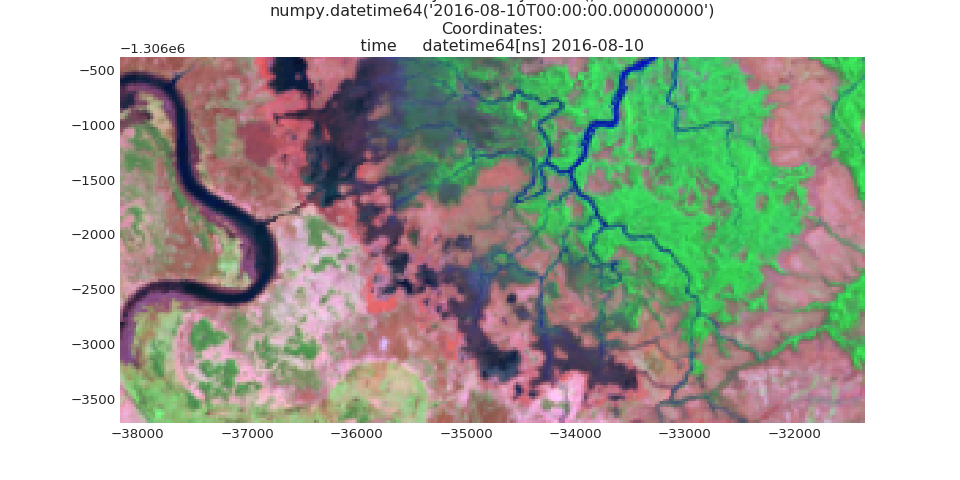

In [183]:
#Click on this image to chose the location for time series extraction
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
#plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r') #turn this on or off to show location of transect
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

fig.canvas.mpl_connect('button_press_event', callback)
date_ = sensor1_nbar.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [214]:
x, y

(-38101, -1307874)

In [215]:
#this converts the map x coordinate into image x coordinates
image_coords = ~affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

## This section is for viewing a time series of different indices - and retrieving the image that corresponds with a particular point on a time series

In [216]:
#retrieve the time series for the pixel location clicked above
ts_sensor1 = sensor1_nbar.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')
ts_sensor2 = sensor2_nbar.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')
ts_sensor3 = sensor3_nbar.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')

In [217]:
#Calculate time series of total suspended matter
ts_tsm_sensor1 = (tsm_coeff[sensor1][0]*((ts_sensor1.green + ts_sensor1.red)/20000)**tsm_coeff[sensor1][1])
ts_tsm_sensor2 = (tsm_coeff[sensor2][0]*((ts_sensor2.green + ts_sensor2.red)/20000)**tsm_coeff[sensor2][1])
ts_tsm_sensor3 = (tsm_coeff[sensor3][0]*((ts_sensor3.green + ts_sensor3.red)/20000)**tsm_coeff[sensor3][1])
ts_tsm_multi = xr.concat([ts_tsm_sensor1, ts_tsm_sensor2, ts_tsm_sensor3], dim = 'time')
time_sorted = ts_tsm_multi.time.argsort()
ts_tsm_multi = ts_tsm_multi.isel(time=time_sorted)

In [218]:
#Calculate Taselled Cap Brightness
ts_brightness_sensor1 = ((ts_sensor1.blue*brightness_coeff[sensor1][0])+(ts_sensor1.green*brightness_coeff[sensor1][1])+
                          (ts_sensor1.red*brightness_coeff[sensor1][2])+(ts_sensor1.nir*brightness_coeff[sensor1][3])+
                          (ts_sensor1.swir1*brightness_coeff[sensor1][4])+(ts_sensor1.swir2*brightness_coeff[sensor1][5]))
ts_brightness_sensor2 = ((ts_sensor2.blue*brightness_coeff[sensor2][0])+(ts_sensor2.green*brightness_coeff[sensor2][1])+
                          (ts_sensor2.red*brightness_coeff[sensor2][2])+(ts_sensor2.nir*brightness_coeff[sensor2][3])+
                          (ts_sensor2.swir1*brightness_coeff[sensor2][4])+(ts_sensor2.swir2*brightness_coeff[sensor2][5]))
ts_brightness_sensor3 = ((ts_sensor3.blue*brightness_coeff[sensor3][0])+(ts_sensor3.green*brightness_coeff[sensor3][1])+
                          (ts_sensor3.red*brightness_coeff[sensor3][2])+(ts_sensor3.nir*brightness_coeff[sensor3][3])+
                          (ts_sensor3.swir1*brightness_coeff[sensor3][4])+(ts_sensor3.swir2*brightness_coeff[sensor3][5]))
ts_brightness_multi = xr.concat([ts_brightness_sensor1, ts_brightness_sensor2, ts_brightness_sensor3], dim = 'time')
time_sorted = ts_brightness_multi.time.argsort()
ts_brightness_multi = ts_brightness_multi.isel(time=time_sorted)

In [219]:
#Calculate Taselled Cap greenness
ts_greenness_sensor1 = ((ts_sensor1.blue*greenness_coeff[sensor1][0])+(ts_sensor1.green*greenness_coeff[sensor1][1])+
                          (ts_sensor1.red*greenness_coeff[sensor1][2])+(ts_sensor1.nir*greenness_coeff[sensor1][3])+
                          (ts_sensor1.swir1*greenness_coeff[sensor1][4])+(ts_sensor1.swir2*greenness_coeff[sensor1][5]))
ts_greenness_sensor2 = ((ts_sensor2.blue*greenness_coeff[sensor2][0])+(ts_sensor2.green*greenness_coeff[sensor2][1])+
                          (ts_sensor2.red*greenness_coeff[sensor2][2])+(ts_sensor2.nir*greenness_coeff[sensor2][3])+
                          (ts_sensor2.swir1*greenness_coeff[sensor2][4])+(ts_sensor2.swir2*greenness_coeff[sensor2][5]))
ts_greenness_sensor3 = ((ts_sensor3.blue*greenness_coeff[sensor3][0])+(ts_sensor3.green*greenness_coeff[sensor3][1])+
                          (ts_sensor3.red*greenness_coeff[sensor3][2])+(ts_sensor3.nir*greenness_coeff[sensor3][3])+
                          (ts_sensor3.swir1*greenness_coeff[sensor3][4])+(ts_sensor3.swir2*greenness_coeff[sensor3][5]))
ts_greenness_multi = xr.concat([ts_greenness_sensor1, ts_greenness_sensor2, ts_greenness_sensor3], dim = 'time')
time_sorted = ts_greenness_multi.time.argsort()
ts_greenness_multi = ts_greenness_multi.isel(time=time_sorted)

In [220]:
#Calculate Taselled Cap wetness
ts_wetness_sensor1 = ((ts_sensor1.blue*wetness_coeff[sensor1][0])+(ts_sensor1.green*wetness_coeff[sensor1][1])+
                          (ts_sensor1.red*wetness_coeff[sensor1][2])+(ts_sensor1.nir*wetness_coeff[sensor1][3])+
                          (ts_sensor1.swir1*wetness_coeff[sensor1][4])+(ts_sensor1.swir2*wetness_coeff[sensor1][5]))
ts_wetness_sensor2 = ((ts_sensor2.blue*wetness_coeff[sensor2][0])+(ts_sensor2.green*wetness_coeff[sensor2][1])+
                          (ts_sensor2.red*wetness_coeff[sensor2][2])+(ts_sensor2.nir*wetness_coeff[sensor2][3])+
                          (ts_sensor2.swir1*wetness_coeff[sensor2][4])+(ts_sensor2.swir2*wetness_coeff[sensor2][5]))
ts_wetness_sensor3 = ((ts_sensor3.blue*wetness_coeff[sensor3][0])+(ts_sensor3.green*wetness_coeff[sensor3][1])+
                          (ts_sensor3.red*wetness_coeff[sensor3][2])+(ts_sensor3.nir*wetness_coeff[sensor3][3])+
                          (ts_sensor3.swir1*wetness_coeff[sensor3][4])+(ts_sensor3.swir2*wetness_coeff[sensor3][5]))
ts_wetness_multi = xr.concat([ts_wetness_sensor1, ts_wetness_sensor2, ts_wetness_sensor3], dim = 'time')
time_sorted = ts_wetness_multi.time.argsort()
ts_wetness_multi = ts_wetness_multi.isel(time=time_sorted)

In [221]:
#Calculate time series of normalised difference indices
ts_multi = xr.concat([ts_sensor1, ts_sensor2, ts_sensor3], dim = 'time')
time_sorted = ts_multi.time.argsort()
ts_multi = ts_multi.isel(time=time_sorted)
ts_multi_ndvi = ((ts_multi.nir-ts_multi.red)/(ts_multi.nir+ts_multi.red))
ts_multi_nbr = ((ts_multi.nir-ts_multi.swir2)/(ts_multi.nir+ts_multi.swir2))
#NBR as defined in http://www.sciencedirect.com/science/article/pii/S0034425706005128
ts_multi_ndwi = ((ts_multi.nir-ts_multi.swir1)/(ts_multi.nir+ts_multi.swir1))
#NDWI as per http://www.sciencedirect.com/science/article/pii/S0034425703003353 and 
#http://www.sciencedirect.com/science/article/pii/S0034425796000673


<IPython.core.display.Javascript object>


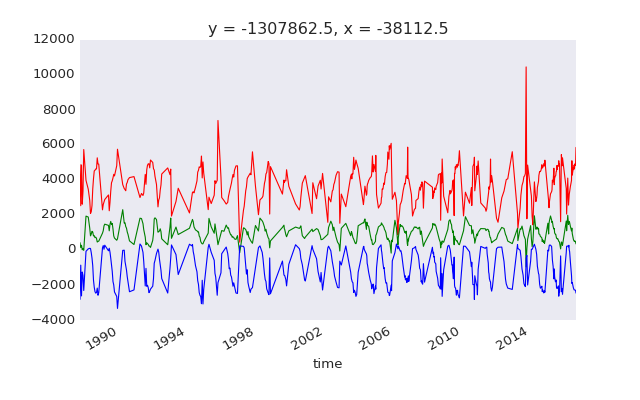

In [222]:
#Plot Taselled Cap Indices
fig = plt.figure(figsize=(8,5))
#ts_tsm_sensor1.plot()
ts_brightness_multi.plot(c = 'r')
ts_greenness_multi.plot(c = 'g')
ts_wetness_multi.plot(c = 'b')

<IPython.core.display.Javascript object>


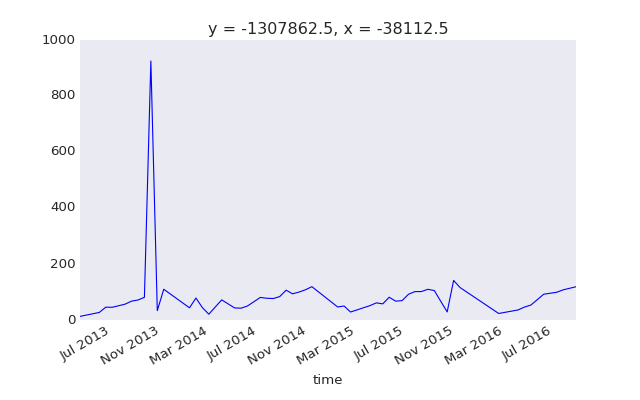

In [223]:
#Plot time series of total suspended matter (only valid over optically deep water)
fig = plt.figure(figsize=(8,5))
ts_tsm_sensor1.plot()

<IPython.core.display.Javascript object>


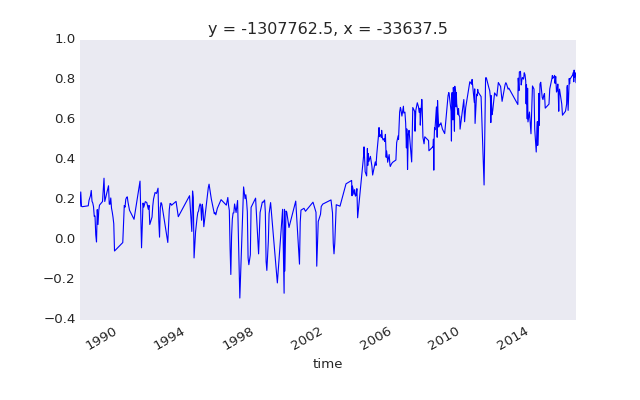

In [202]:
fig = plt.figure(figsize=(8,5))
ts_multi_ndvi.plot()



<IPython.core.display.Javascript object>


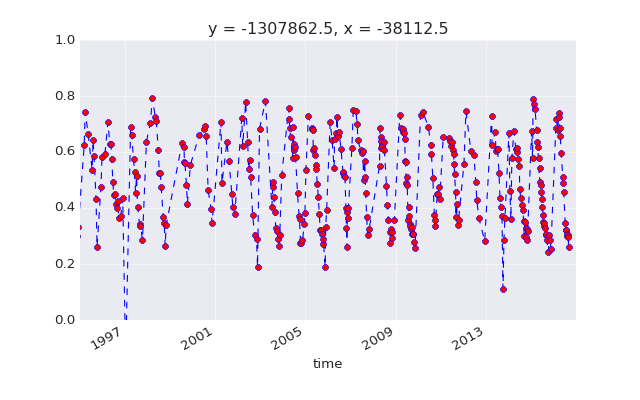

['1995-01-01', '2016-12-31', 0, 1]

In [228]:
#Use this plot to visualise a time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure(figsize=(8,5))


fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

firstyear = '1995-01-01'
lastyear = '2016-12-31'
#all_tss_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
ts_multi_ndvi.plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='r')
plt.grid()
#water_only.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'm', marker = '8', mec = 'b', mfc ='m')
plt.axis([firstyear , lastyear ,0, 1])

In [210]:
time_slice = matplotlib.dates.num2date(time_int).date()
#This will work for time series that correspond with sensor1
rgb = sensor1_nbar.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled4 = (clipped_visible / max_val)

In [211]:
time_slice

datetime.date(2016, 8, 11)

<IPython.core.display.Javascript object>


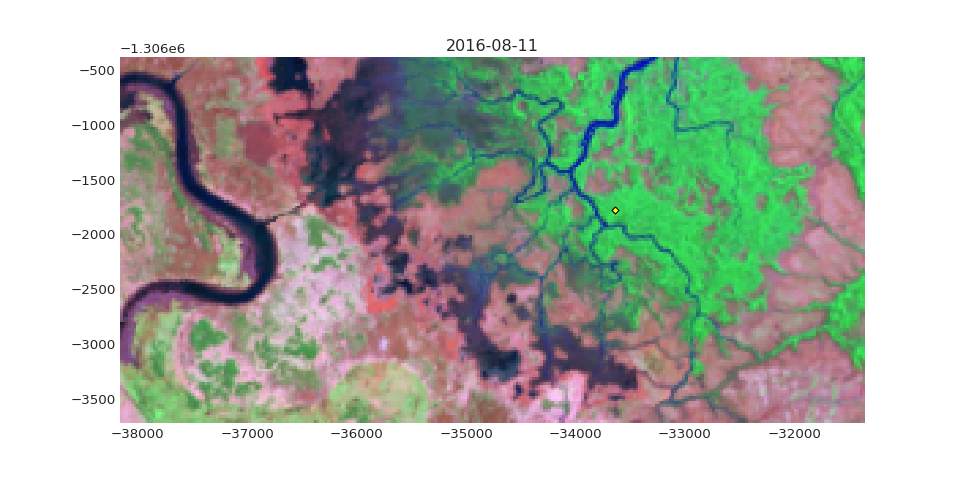

In [212]:
#This image shows the time slice of choice and the location of the time series 
fig = plt.figure(figsize =(12,6))
#plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')
plt.imshow(scaled4, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.title(time_slice)
plt.show()

## View the phenology of the time series

<IPython.core.display.Javascript object>


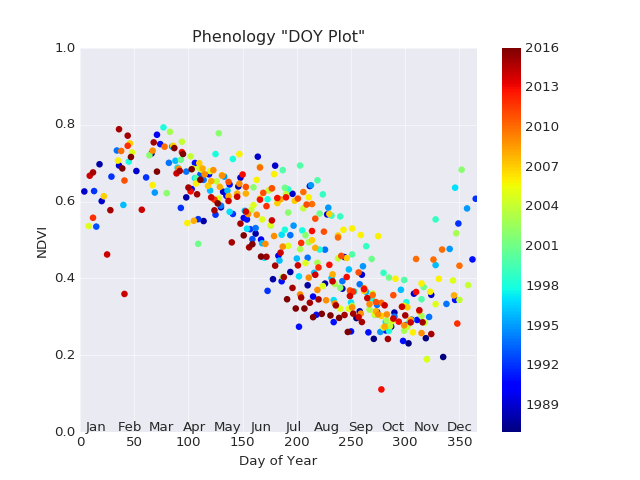

In [225]:
ts = ts_multi_ndvi
#This is the phenology stacking code from Chris Holden - Boston University
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
ax.set_ylim((0, 1))
ax.set_xlabel('Day of Year')
ax.set_ylabel('NDVI')
ax.set_title('Phenology "DOY Plot"')

In [55]:
#This controls the colour maps used for plotting NDVI, TSS and Normalised Burn Ratio
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])
nbr_cmap = mpl.colors.ListedColormap(['darkslategray','dimgray' , 'lightgrey' , '#ccff66' , '#2eb82e', '#009933'])

ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
nbr_bounds = [-1, -0.1, 0, 0.1, 0.2, 0.4, 0.6]
tss_bounds = [0, 10, 20, 50, 80, 100, 150]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
nbr_norm = mpl.colors.BoundaryNorm(nbr_bounds, nbr_cmap.N)

## View a hovmoller plot for the transect

In [82]:
#Retrieve the hovmoller data volumes and concatenate them
geom_w = warp_geometry(geom, query['crs'], crs.wkt)
hov_sensor1 = transect(sensor1_nbar, geom_w, 25)
hov_sensor2 = transect(sensor2_nbar, geom_w, 25)
hov_sensor3 = transect(sensor3_nbar, geom_w, 25)
hov_multi = xr.concat([hov_sensor1, hov_sensor2, hov_sensor3], dim = 'time')
time_sorted = hov_multi.time.argsort()
hov_multi = hov_multi.isel(time=time_sorted)

In [83]:
hov_multi.dims

Frozen(SortedKeysDict(OrderedDict([('distance', 353), ('time', 565)])))

In [110]:
hov_multi.red.shape

(353, 565)

In [145]:
pernan = 1

print int(pernan*hov_multi.distance.size)

353


In [147]:
hov_multi

<xarray.Dataset>
Dimensions:   (distance: 353, time: 565)
Coordinates:
    y         (distance) float64 -1.31e+06 -1.31e+06 -1.31e+06 -1.31e+06 ...
    x         (distance) float64 -3.816e+04 -3.816e+04 -3.816e+04 -3.816e+04 ...
  * distance  (distance) int64 0 25 50 75 100 125 150 175 200 225 250 275 ...
  * time      (time) datetime64[ns] 1987-09-12 1987-09-28 1987-10-14 ...
Data variables:
    blue      (distance, time) float64 670.0 nan 906.0 803.0 nan nan 668.0 ...
    swir1     (distance, time) float64 3.332e+03 nan 3.358e+03 3.244e+03 nan ...
    swir2     (distance, time) float64 2.135e+03 nan 2.276e+03 2.235e+03 nan ...
    green     (distance, time) float64 883.0 nan 1.086e+03 1.011e+03 nan nan ...
    nir       (distance, time) float64 1.665e+03 nan 1.982e+03 1.849e+03 nan ...
    red       (distance, time) float64 1.027e+03 nan 1.25e+03 1.176e+03 nan ...
Attributes:
    crs: EPSG:3577
    affine: | 25.00, 0.00,-38175.00|
| 0.00,-25.00,-1306350.00|
| 0.00, 0.00, 1.00|

In [103]:
#hov_multi_drop.red.distance

<IPython.core.display.Javascript object>


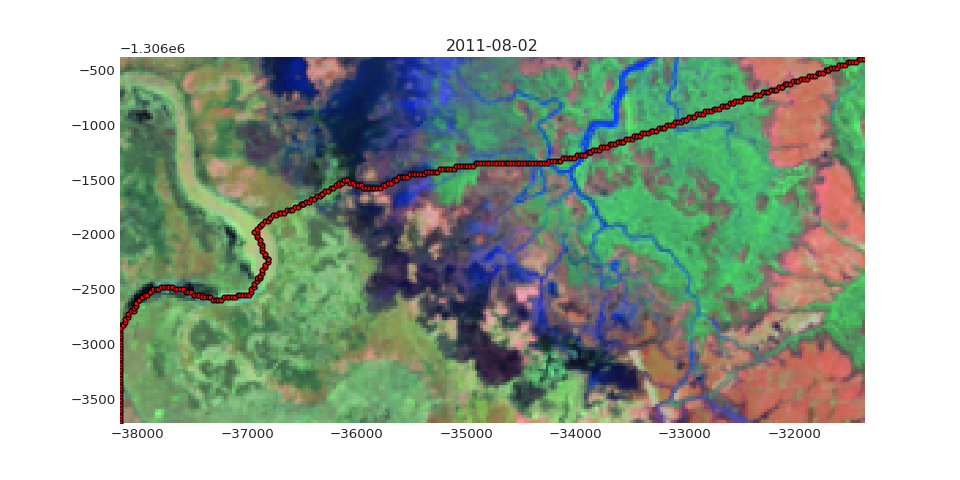

In [90]:
#This image shows the time slice of choice and the location of the time series 
fig = plt.figure(figsize =(12,6))
plt.scatter(x=hov_sensor1.coords['x'], y=hov_sensor1.coords['y'], c='r')
#plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.title(time_slice)
plt.show()

In [169]:
# Set the percentage of good data that you'd like to display with pernan variable - 0.9 will return rows that have 90%
# of valid values
pernan = 0.9

hov_multi_ndvi = ((hov_multi.nir-hov_multi.red)/(hov_multi.nir+hov_multi.red))
hov_multi_nbr = ((hov_multi.nir-hov_multi.swir2)/(hov_multi.nir+hov_multi.swir2))
#NBR as defined in http://www.sciencedirect.com/science/article/pii/S0034425706005128
hov_multi_ndwi = ((hov_multi.nir-hov_multi.swir1)/(hov_multi.nir+hov_multi.swir1))
#NDWI as per http://www.sciencedirect.com/science/article/pii/S0034425703003353 and 
#http://www.sciencedirect.com/science/article/pii/S0034425796000673

#hov_multi_ndvi_drop = ((hov_multi_drop.nir-hov_multi.red)/(hov_multi_drop.nir+hov_multi.red))
hov_multi_ndvi_drop = hov_multi_ndvi.dropna('time',  thresh = int(pernan*hov_multi.distance.size))

In [170]:

#You can check below to see the number of time slices dropped
#Need to check this script
print 'The number of time slices unfiltered = '+ str(hov_multi_ndvi.time.size)
print 'The number of time slices filtered = ' + str(hov_multi_ndvi_drop.time.size)


The number of time slices unfiltered = 565
The number of time slices filtered = 232


<IPython.core.display.Javascript object>


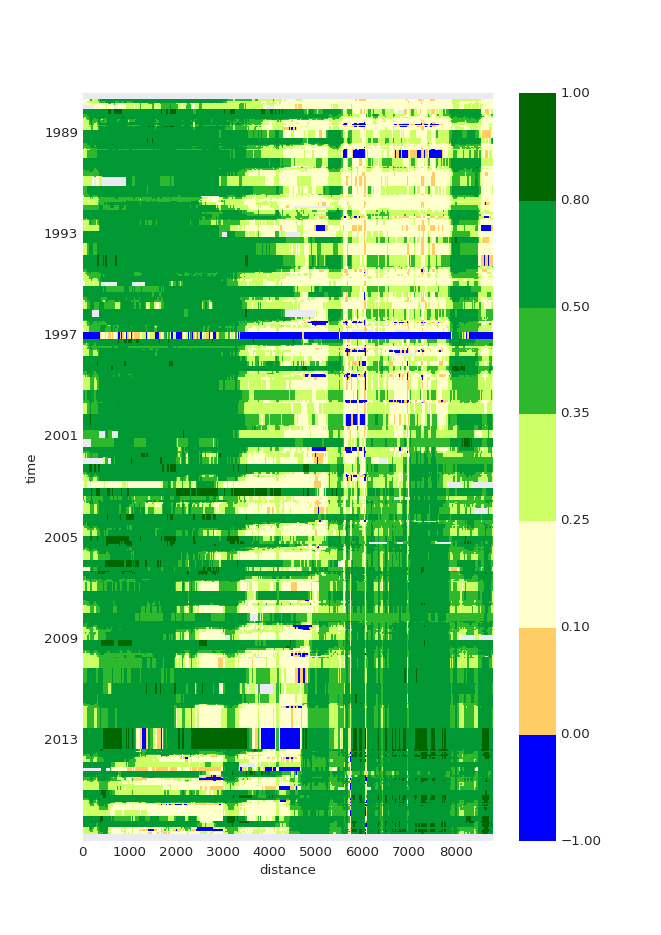

[0, <xarray.DataArray 'distance' ()>
 array(8800), '2016-12-31', '1987-06-01']

In [229]:

#Use firstyear and last year to zoom into periods of interest
firstyearhov = '1987-06-01'
lastyearhov = '2016-12-31'
fig = plt.figure(figsize=(8.27,11.69))
hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
plt.axis([0, hov_multi_drop.distance.max(), lastyearhov , firstyearhov])
#aoi = 'Mary River1' #this aoi string is passed into the PDF file names for all outputs
#savefig('/g/data/r78/lxl554/hovmoller/' + aoi + firstyearhov+lastyearhov+'ndvi_hov.png')

<IPython.core.display.Javascript object>


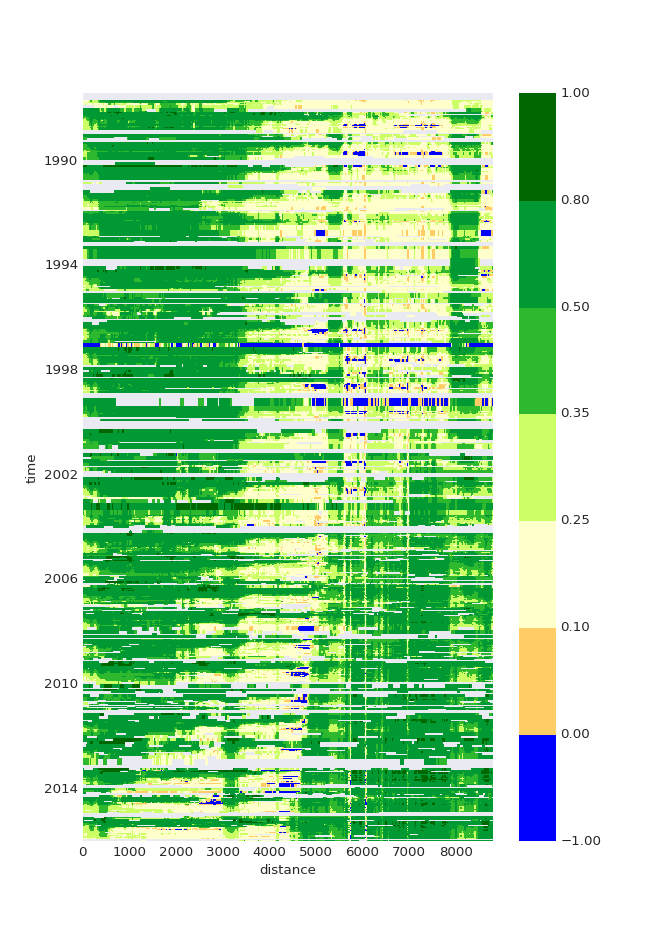

In [62]:
#Use firstyear and last year to zoom into periods of interest
firstyearhov = '1987-06-01'
lastyearhov = '2015-12-31'
fig = plt.figure(figsize=(8.27,11.69))
hov_multi_ndvi.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
plt.axis([0, hov_multi_drop.distance.max(), lastyearhov , firstyearhov])
#aoi = 'Mary River1' #this aoi string is passed into the PDF file names for all outputs
#savefig('/g/data/r78/lxl554/hovmoller/' + aoi + firstyearhov+lastyearhov+'ndvi_hov.png')

In [248]:
#Calculate Taselled Cap Brightness
hov_brightness_sensor1 = ((hov_sensor1.blue*brightness_coeff[sensor1][0])+(hov_sensor1.green*brightness_coeff[sensor1][1])+
                          (hov_sensor1.red*brightness_coeff[sensor1][2])+(hov_sensor1.nir*brightness_coeff[sensor1][3])+
                          (hov_sensor1.swir1*brightness_coeff[sensor1][4])+(hov_sensor1.swir2*brightness_coeff[sensor1][5]))
hov_brightness_sensor2 = ((hov_sensor2.blue*brightness_coeff[sensor2][0])+(hov_sensor2.green*brightness_coeff[sensor2][1])+
                          (hov_sensor2.red*brightness_coeff[sensor2][2])+(hov_sensor2.nir*brightness_coeff[sensor2][3])+
                          (hov_sensor2.swir1*brightness_coeff[sensor2][4])+(hov_sensor2.swir2*brightness_coeff[sensor2][5]))
hov_brightness_sensor3 = ((hov_sensor3.blue*brightness_coeff[sensor3][0])+(hov_sensor3.green*brightness_coeff[sensor3][1])+
                          (hov_sensor3.red*brightness_coeff[sensor3][2])+(hov_sensor3.nir*brightness_coeff[sensor3][3])+
                          (hov_sensor3.swir1*brightness_coeff[sensor3][4])+(hov_sensor3.swir2*brightness_coeff[sensor3][5]))
hov_brightness_multi = xr.concat([hov_brightness_sensor1, hov_brightness_sensor2, hov_brightness_sensor3], dim = 'time')
time_sorted = hov_brightness_multi.time.argsort()
hov_brightness_multi = hov_brightness_multi.isel(time=time_sorted)

#Calculate Taselled Cap Wetness
hov_wetness_sensor1 = ((hov_sensor1.blue*wetness_coeff[sensor1][0])+(hov_sensor1.green*wetness_coeff[sensor1][1])+
                          (hov_sensor1.red*wetness_coeff[sensor1][2])+(hov_sensor1.nir*wetness_coeff[sensor1][3])+
                          (hov_sensor1.swir1*wetness_coeff[sensor1][4])+(hov_sensor1.swir2*wetness_coeff[sensor1][5]))
hov_wetness_sensor2 = ((hov_sensor2.blue*wetness_coeff[sensor2][0])+(hov_sensor2.green*wetness_coeff[sensor2][1])+
                          (hov_sensor2.red*wetness_coeff[sensor2][2])+(hov_sensor2.nir*wetness_coeff[sensor2][3])+
                          (hov_sensor2.swir1*wetness_coeff[sensor2][4])+(hov_sensor2.swir2*wetness_coeff[sensor2][5]))
hov_wetness_sensor3 = ((hov_sensor3.blue*wetness_coeff[sensor3][0])+(hov_sensor3.green*wetness_coeff[sensor3][1])+
                          (hov_sensor3.red*wetness_coeff[sensor3][2])+(hov_sensor3.nir*wetness_coeff[sensor3][3])+
                          (hov_sensor3.swir1*wetness_coeff[sensor3][4])+(hov_sensor3.swir2*wetness_coeff[sensor3][5]))
hov_wetness_multi = xr.concat([hov_wetness_sensor1, hov_wetness_sensor2, hov_wetness_sensor3], dim = 'time')
time_sorted = hov_wetness_multi.time.argsort()
hov_wetness_multi = hov_wetness_multi.isel(time=time_sorted)

#Calculate Taselled Cap Greenness
hov_greenness_sensor1 = ((hov_sensor1.blue*greenness_coeff[sensor1][0])+(hov_sensor1.green*greenness_coeff[sensor1][1])+
                          (hov_sensor1.red*greenness_coeff[sensor1][2])+(hov_sensor1.nir*greenness_coeff[sensor1][3])+
                          (hov_sensor1.swir1*greenness_coeff[sensor1][4])+(hov_sensor1.swir2*greenness_coeff[sensor1][5]))
hov_greenness_sensor2 = ((hov_sensor2.blue*greenness_coeff[sensor2][0])+(hov_sensor2.green*greenness_coeff[sensor2][1])+
                          (hov_sensor2.red*greenness_coeff[sensor2][2])+(hov_sensor2.nir*greenness_coeff[sensor2][3])+
                          (hov_sensor2.swir1*greenness_coeff[sensor2][4])+(hov_sensor2.swir2*greenness_coeff[sensor2][5]))
hov_greenness_sensor3 = ((hov_sensor3.blue*greenness_coeff[sensor3][0])+(hov_sensor3.green*greenness_coeff[sensor3][1])+
                          (hov_sensor3.red*greenness_coeff[sensor3][2])+(hov_sensor3.nir*greenness_coeff[sensor3][3])+
                          (hov_sensor3.swir1*greenness_coeff[sensor3][4])+(hov_sensor3.swir2*greenness_coeff[sensor3][5]))
hov_greenness_multi = xr.concat([hov_greenness_sensor1, hov_greenness_sensor2, hov_greenness_sensor3], dim = 'time')
time_sorted = hov_greenness_multi.time.argsort()
hov_greenness_multi = hov_greenness_multi.isel(time=time_sorted)

<IPython.core.display.Javascript object>


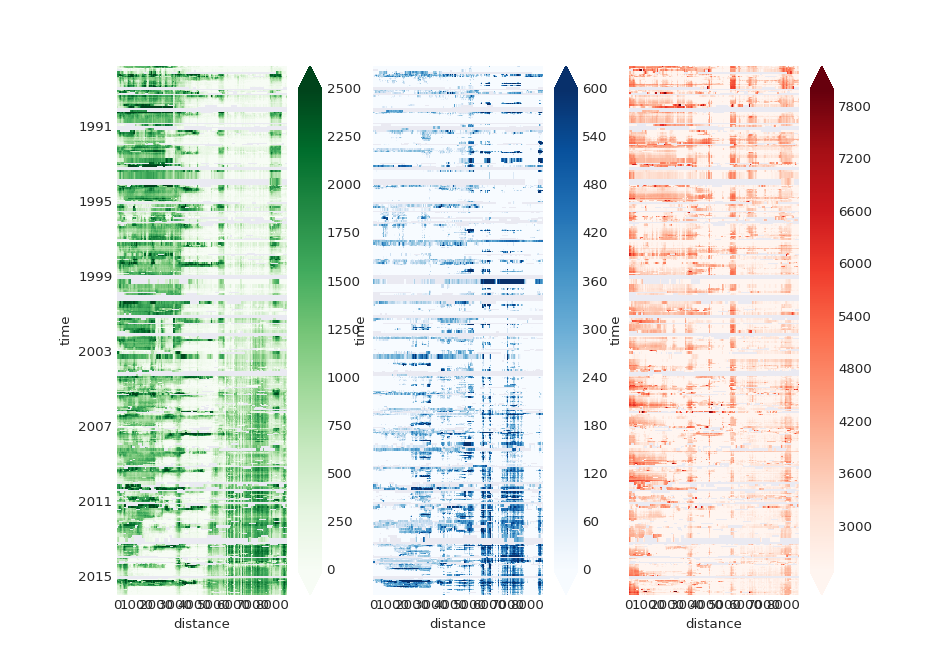

In [291]:
fig = plt.figure(figsize=(11.69,8.27))
gs = gridspec.GridSpec(1, 3)
green_min = 0
green_max = 2500
wet_min = 0
wet_max = 600
bright_min = 2500
bright_max = 8000
ax1 = plt.subplot(gs[0, 0])
ax1 = hov_greenness_multi.plot(x='distance', y='time', yincrease = False, cmap = 'Greens', 
                               vmin = green_min, vmax = green_max)

ax2 = plt.subplot(gs[0, 1])
ax2 = hov_wetness_multi.plot(x='distance', y='time', yincrease = False, cmap = 'Blues', 
                             vmin = wet_min, vmax = wet_max)
ax2 = plt.tick_params(axis = 'y',labelleft = 'off')

ax3 = plt.subplot(gs[0, 2])
ax3 = hov_brightness_multi.plot(x='distance', y='time', yincrease = False, cmap = 'Reds', 
                                vmin = bright_min, vmax = bright_max)
ax3 = plt.tick_params(axis = 'y',labelleft = 'off')


In [231]:
s1_ndvi = ((sensor1_nbar.nir - sensor1_nbar.red)/(sensor1_nbar.nir + sensor1_nbar.red))
s2_ndvi = ((sensor2_nbar.nir - sensor2_nbar.red)/(sensor2_nbar.nir + sensor2_nbar.red))
s3_ndvi = ((sensor3_nbar.nir - sensor3_nbar.red)/(sensor3_nbar.nir + sensor3_nbar.red))

all_ndvi_sorted = xr.concat([s1_ndvi, s2_ndvi, s3_ndvi], dim='time')
time_sorted = all_ndvi_sorted.time.argsort()
all_ndvi_sorted = all_ndvi_sorted.isel(time=time_sorted)
all_ndvi_sorted.attrs['crs'] = crs
all_ndvi_sorted.attrs['affine'] = affine

<IPython.core.display.Javascript object>


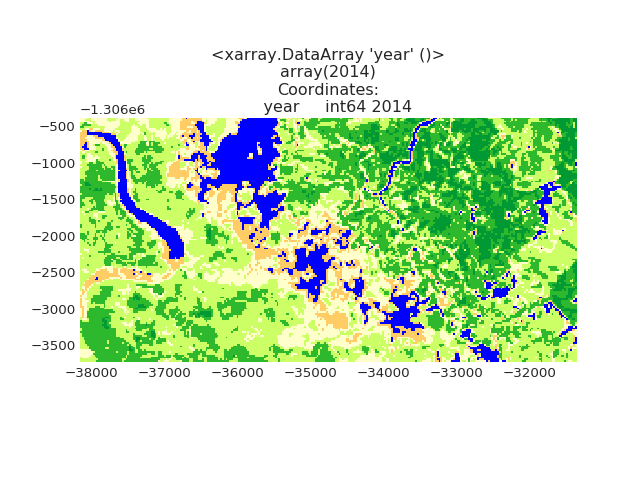

In [233]:
annual_ndvi = all_ndvi_sorted.groupby('time.year')
annual_min = annual_ndvi.min(dim = 'time')
fig = plt.figure()
i = 27
plt.title(annual_min.year[i])

plt.imshow(annual_min[i], interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm,
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

<IPython.core.display.Javascript object>


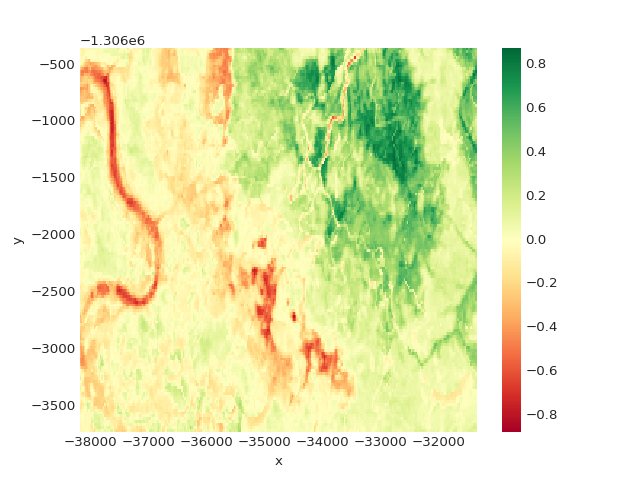

In [359]:
fig = plt.figure()
y1 = 1
y2 = 28
nd_dif = annual_min[y2] - annual_min[y1]
nd_dif.plot(cmap = 'RdYlGn')

<IPython.core.display.Javascript object>


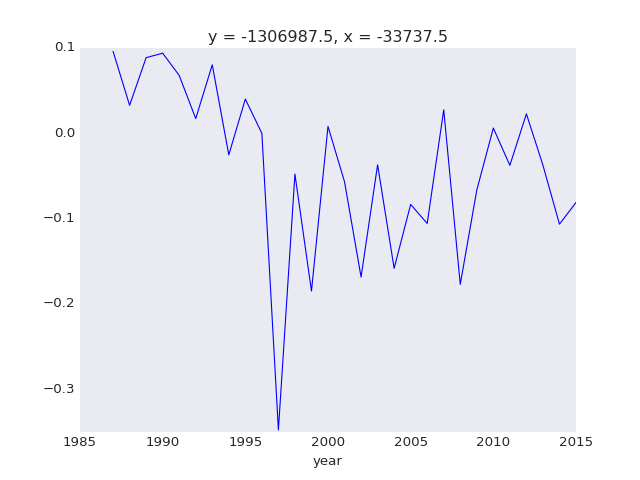

In [287]:
fig = plt.figure()
ndvi_annual_min_ts = annual_min.isel(x=[imagex],y=[imagey])
ndvi_annual_min_ts.plot()

## Use this section to select a series of images to add to multi-panel figures and export to PDF

In [ ]:
#Use this plot to visualise a time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure(figsize=(12,5))


fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

firstyear = '1987-01-01'
lastyear = '2015-12-31'
#all_tss_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
all_ndvi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')
plt.grid()
#water_only.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'm', marker = '8', mec = 'b', mfc ='m')
plt.axis([firstyear , lastyear ,0, 1])

In [ ]:
time_slice = matplotlib.dates.num2date(time_int).date()
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled2 = (clipped_visible / max_val)
fig = plt.figure(figsize =(12,6))
#plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')
plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.title(time_slice)
plt.show()

In [ ]:
#execute these cells if the image corresponds to the appropriate period of interest 
# time slice 1 - reference, time slice 2 - immediately prior to change, time slice 3 - after change
scaled1 = scaled
time_slice1 = time_slice
print time_slice1

In [ ]:
scaled2 = scaled
time_slice2 = time_slice
print time_slice2

In [ ]:
scaled3 = scaled
time_slice3 = time_slice
print time_slice3

In [ ]:
#Use the 3 time slices and populate the figure with them

date = time_slice1
date2 = time_slice2
date3 = time_slice3

fig = plt.figure(figsize=(11.69,8.27))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, 0])
ax1 = plt.imshow(scaled1, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
ax1 = title(pd.to_datetime(date).strftime('%Y-%m-%d'))
ax1 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax1 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax1 = plt.axis('image')
#ax1 = plt.plot([x,x], [0, all_ndvi_sorted.shape[1]], 'r')
#ax1 = plt.scatter(x = [imagex], y = [imagey], c= 'yellow', marker = 'D')
ax1 = plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')

ax2 = plt.subplot(gs[1, 0])
ax2 = plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
ax2 = title(pd.to_datetime(date2).strftime('%Y-%m-%d'))
ax2 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax2 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')

ax3 = plt.subplot(gs[2, 0])
ax3 = plt.imshow(scaled3, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
ax3 = title(pd.to_datetime(date3).strftime('%Y-%m-%d'))
ax3 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax3 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')

ax4 = plt.subplot(gs[:,1])
ax4 = plt.grid(color = 'r', linestyle = '--')
#ax4 = imshow(rsindex_subs['NDWI'].as_matrix(range(3,len(rsindex_subs['NDVI'].columns))), aspect='auto', vmin=ndmin, vmax=ndmax)
ax4 = trans_drop.plot(x='distance', y='time', vmin = 0, vmax = 150, yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)


In [ ]:
#If you're happy with the figure use this cell to print it out
aoi = 'Dalhousie Mound Springs' #this aoi string is passed into the PDF file names for all outputs
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + '3image_hov.pdf'
with PdfPages(out_fname) as pdf:
    date = time_slice1
    date2 = time_slice2
    date3 = time_slice3

    fig = plt.figure(figsize=(11.69,8.27))
    gs = gridspec.GridSpec(3, 2)
    ax1 = plt.subplot(gs[0, 0])
    ax1 = plt.imshow(scaled1, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ax1 = title(pd.to_datetime(date).strftime('%Y-%m-%d'))
    ax1 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
    ax1 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
    ax1 = plt.axis('image')
    #ax1 = plt.plot([x,x], [0, all_ndvi_sorted.shape[1]], 'r')
    #ax1 = plt.scatter(x = [imagex], y = [imagey], c= 'yellow', marker = 'D')
    ax1 = plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')

    ax2 = plt.subplot(gs[1, 0])
    ax2 = plt.imshow(scaled2, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ax2 = title(pd.to_datetime(date2).strftime('%Y-%m-%d'))
    ax2 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
    ax2 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')

    ax3 = plt.subplot(gs[2, 0])
    ax3 = plt.imshow(scaled3, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ax3 = title(pd.to_datetime(date3).strftime('%Y-%m-%d'))
    ax3 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
    ax3 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')

    ax4 = plt.subplot(gs[:,1])
    ax4 = plt.grid(color = 'r', linestyle = '--')
    #ax4 = imshow(rsindex_subs['NDWI'].as_matrix(range(3,len(rsindex_subs['NDVI'].columns))), aspect='auto', vmin=ndmin, vmax=ndmax)
    ax4 = trans_drop.plot(x='distance', y='time', vmin = 0, vmax = 150, yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)

    pdf.savefig()

In [ ]:
#This figure presents the three image chips in the context of a time series
#use the first and last year to focus in on periods of interest - these will also be passed into the PDF file names
plotfirstyear = '1987-01-01'
plotlastyear = '2016-12-31'

fig = plt.figure(figsize=(11.69,8.27))
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0, 0])
ax1 = plt.imshow(scaled1, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
ax1 = title(time_slice1)
ax1 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax1 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax1 = plt.axis('image')
ax1 = plt.scatter(x=[x], y=[y], c='r')

ax2 = plt.subplot(gs[0, 1])
ax2 = plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
ax2 = title(time_slice2)
ax2 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax2 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax2 = plt.axis('image')
ax2 = plt.scatter(x=[x], y=[y], c='r')

ax3 = plt.subplot(gs[0, 2])
ax3 = plt.imshow(scaled3, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
ax3 = title(time_slice3)
ax3 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax3 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax3 = plt.axis('image')
ax3 = plt.scatter(x=[x], y=[y], c='r')

ax4 = plt.subplot(gs[1,:])
ax4 = all_ndvi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
ax4 = plt.axis([plotfirstyear , plotlastyear ,0.1, 0.9])

In [ ]:
#If happy with the time series plot - save it as a PDF
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + '3image_NDVI_ts.pdf'
with PdfPages(out_fname) as pdf:

    fig = plt.figure(figsize=(11.69,8.27))
    gs = gridspec.GridSpec(2, 3)
    ax1 = plt.subplot(gs[0, 0])
    ax1 = plt.imshow(scaled1, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ax1 = title(time_slice1)
    ax1 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
    ax1 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
    ax1 = plt.axis('image')
    ax1 = plt.scatter(x=[x], y=[y], c='r')

    ax2 = plt.subplot(gs[0, 1])
    ax2 = plt.imshow(scaled2, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ax2 = title(time_slice2)
    ax2 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
    ax2 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
    ax2 = plt.axis('image')
    ax2 = plt.scatter(x=[x], y=[y], c='r')

    ax3 = plt.subplot(gs[0, 2])
    ax3 = plt.imshow(scaled3, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])
    ax3 = title(time_slice3)
    ax3 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
    ax3 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
    ax3 = plt.axis('image')
    ax3 = plt.scatter(x=[x], y=[y], c='r')

    ax4 = plt.subplot(gs[1,:])
    ax4 = all_ndvi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
    ax4 = plt.axis([plotfirstyear , plotlastyear ,0.1, 0.9])

    pdf.savefig()

## Work in progress below this point - trying to get sea level data in

In [362]:

ds = xr.open_dataset('/g/data/r78/lxl554/hovmoller/slr_sla_int_keep_all_66.nc', decode_times = False)

In [363]:

from datetime import datetime, timedelta

ds = xr.open_dataset('/g/data/r78/lxl554/hovmoller/slr_sla_int_free_all_66.nc', decode_times=False)


# No leap years!!!
def convert_fractional_year(number):
    year = int(number)
    d = np.timedelta64(int((number - year)*365), 'D')
    day_one = np.datetime64(datetime(year,1,1))
    date = d + day_one
    return date

for c_name, c_vals in ds.coords.items():
    c_vals.data = np.array(map(convert_fractional_year, c_vals.data))


ds.sla_tx.plot()
#ds

ValueError: ordinal must be >= 1

In [ ]:
#ig = plt.figure(figsize=(11.69,5))
ds['sla_tx'].time_tx

In [ ]:
test = ds['sla_tx'][0]

In [ ]:
test.time_tx

In [ ]:
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + '3image_NDVI.pdf'
with PdfPages(out_fname) as pdf:
    #put the figure creation gumph in here
    pdf.savefig()

In [ ]:
#if the figure above is the one you want to save to PDF use this cell
aoi = 'Dalhousie Mound Springs'
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + str(time_slice)+ '.pdf'
with PdfPages(out_fname) as pdf:
    #put the figure creation gumph in here
    fig = plt.figure(figsize =(11.69,8.27))
    #plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')

    plt.imshow(scaled2, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])

    #plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')

    plt.title(time_slice)
    plt.show()
    pdf.savefig()
